In [37]:
suppressPackageStartupMessages(library(cicero))

In [38]:
set.seed(0)

wd = '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/cicero'
sc.data <- t(readMM(file.path(wd, 'Islet_123.peaks.mtx')))
peaks <- read.table(file.path(wd, 'Islet_123.peaks.peaks'), header=F)
barcodes <- read.table(file.path(wd, 'Islet_123.peaks.barcodes'), header=F)
rownames(sc.data) <- paste0('chr', gsub('-','_', gsub(':','_',peaks[,1])))
colnames(sc.data) <- barcodes[,1]

sc.umap <- read.table(file.path('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only', 'Islet_123.MNN_corrected.delta_fixed.txt'), sep='\t', header=T, row.names=1)
cellinfo <-data.frame(cells=colnames(sc.data))
cellinfo <- cbind(cellinfo, sc.umap[c('cluster','log10_n_counts')])
row.names(cellinfo) <- cellinfo$cells
dhsinfo <- data.frame(site_name=rownames(sc.data))
dhsinfo <- cbind(dhsinfo, stringr::str_split_fixed(dhsinfo$site_name, "_", 3))
row.names(dhsinfo) <- dhsinfo$site_name
names(dhsinfo) <- c('site_name','chr','bp1','bp2')
dhsinfo$chr <- gsub('chr','', dhsinfo$chr)
dhsinfo$bp1 <- as.numeric(as.character(dhsinfo$bp1))
dhsinfo$bp2 <- as.numeric(as.character(dhsinfo$bp2))

clusters <- c('delta_1','delta_2')
input_cds <- suppressWarnings(newCellDataSet(as(sc.data, 'dgCMatrix'),
                            phenoData = methods::new('AnnotatedDataFrame', data = cellinfo),
                            featureData = methods::new('AnnotatedDataFrame', data = dhsinfo),
                            expressionFamily=negbinomial.size(),
                            lowerDetectionLimit=0))
input_cds@expressionFamily <- binomialff()
input_cds@expressionFamily@vfamily <- 'binomialff'
input_cds <- input_cds[, pData(input_cds)[['cluster']] %in% clusters]
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) > 0,]
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)

pData(input_cds)['delta'] <- as.numeric(gsub('delta_', '', pData(input_cds)$cluster))

In [39]:
agg_cds <- aggregate_nearby_peaks(input_cds, distance = 10000)
agg_cds <- detectGenes(agg_cds)
agg_cds <- estimateSizeFactors(agg_cds)
agg_cds <- estimateDispersions(agg_cds)
pData(agg_cds)$donor = stringr::str_split_fixed(pData(agg_cds)$cells, '-', 2)[,1]

Removing 1112 outliers


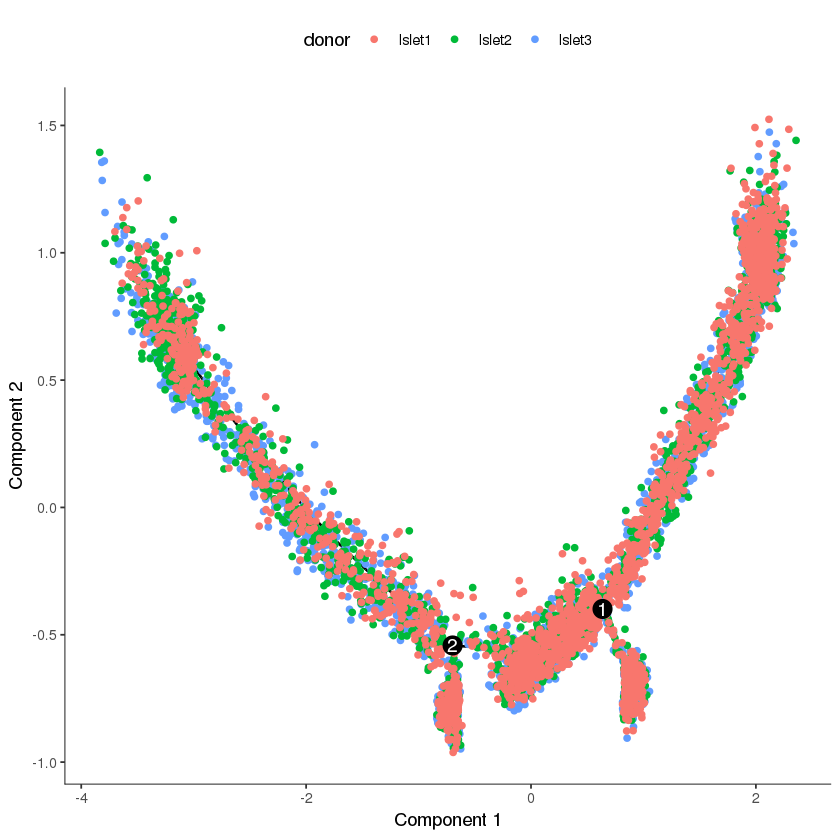

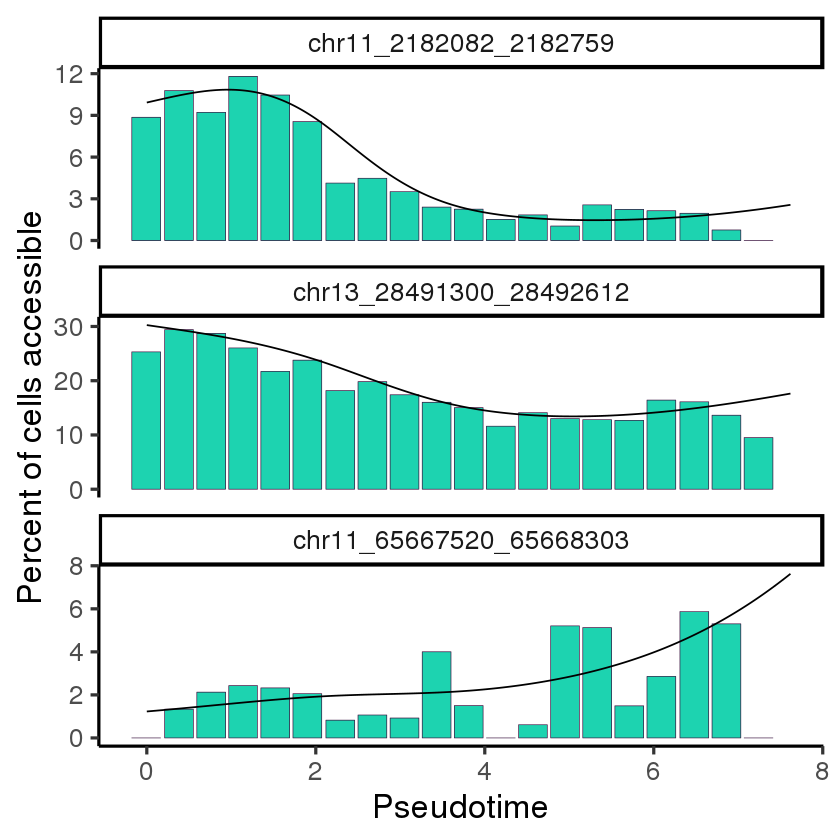

In [11]:
difftest_res <- read.table(file.path('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime', 'Islet_123.beta.pseudotime_difftest2.txt'), sep='\t', header=T)
difftest_res <- difftest_res[difftest_res$qval < .1,]
agg_cds <- setOrderingFilter(agg_cds, rownames(difftest_res))
agg_cds <- reduceDimension(agg_cds, max_components = 2, residualModelFormulaStr='~as.numeric(num_genes_expressed)', reduction_method = 'DDRTree')
agg_cds <- orderCells(agg_cds)
pData(agg_cds)$Pseudotime <- max(pData(agg_cds)$Pseudotime) - pData(agg_cds)$Pseudotime
pData(input_cds)$Pseudotime <- pData(agg_cds)[colnames(input_cds),]$Pseudotime
pData(input_cds)$State <- pData(agg_cds)[colnames(input_cds),]$State


options(repr.plot.width=7, repr.plot.height=7)
plot_cell_trajectory(agg_cds, color_by = 'donor')# + theme_void(base_size=20)
#plot_accessibility_in_pseudotime(input_cds[c('chr11_2182082_2182759', 'chr13_28491300_28492612','chr11_65667520_65668303')], breaks=20) + theme_classic(base_size=20) 
plot_accessibility_in_pseudotime(input_cds[c('chr3_187387813_187388546', 'chr13_28491300_28492612','chr10_94448759_94450496')], breaks=20) + theme_classic(base_size=20) 
#plot_accessibility_in_pseudotime(input_cds[c('chr2_163007714_163009071', 'chr11_65667520_65668303', 'chr20_48598805_48600728')], breaks=20) + theme_classic(base_size=20) 


Warning message:
"Removed 3 rows containing missing values (position_stack)."

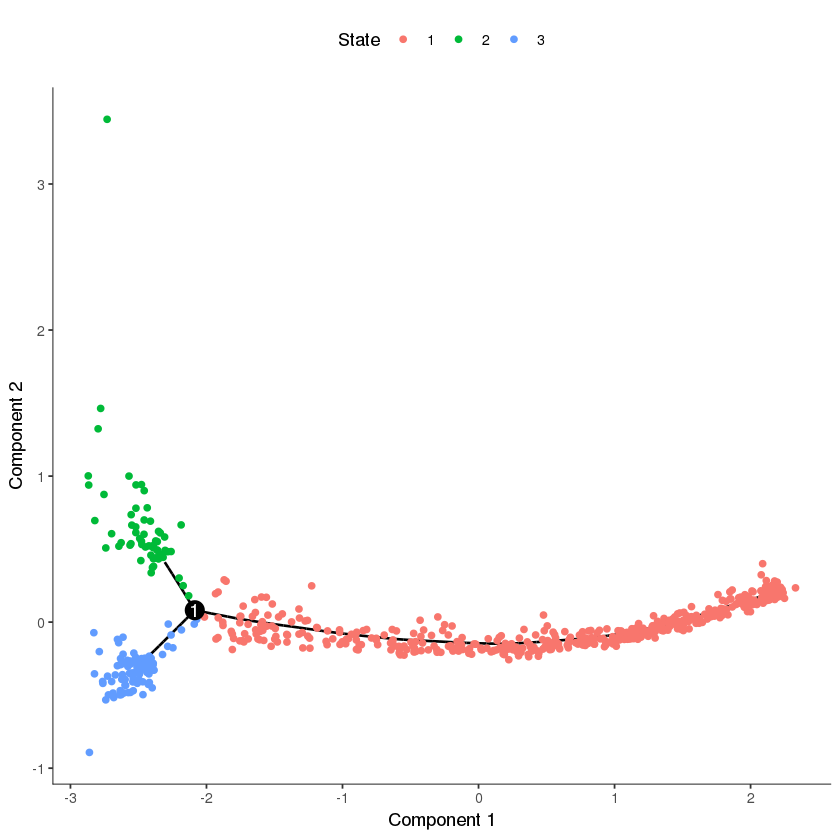

Warning message:
"Removed 3 rows containing missing values (position_stack)."

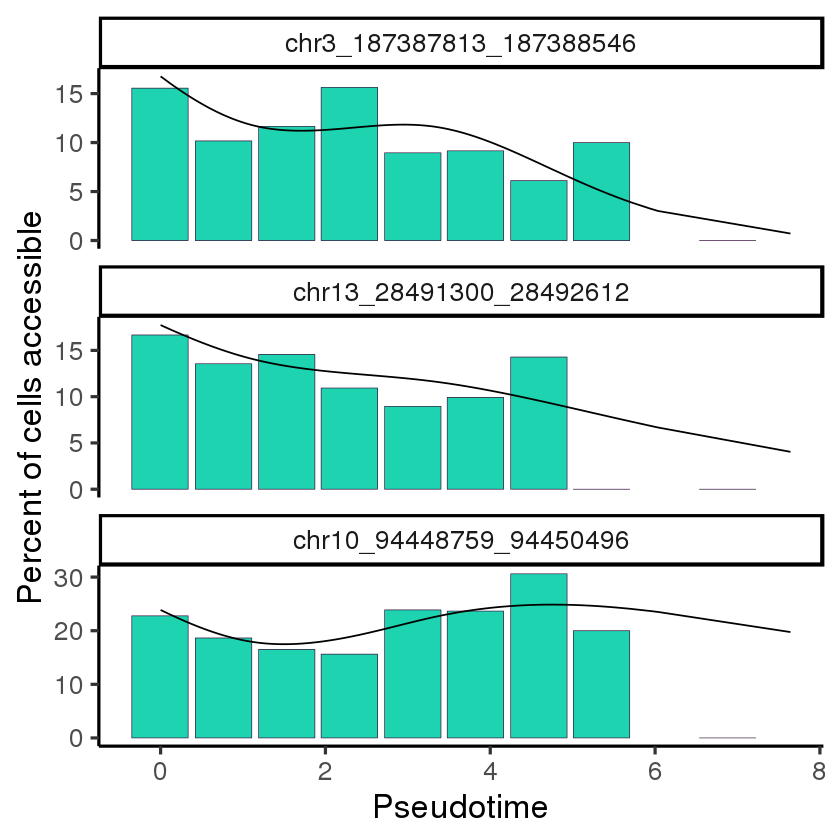

Warning message:
"Removed 3 rows containing missing values (position_stack)."

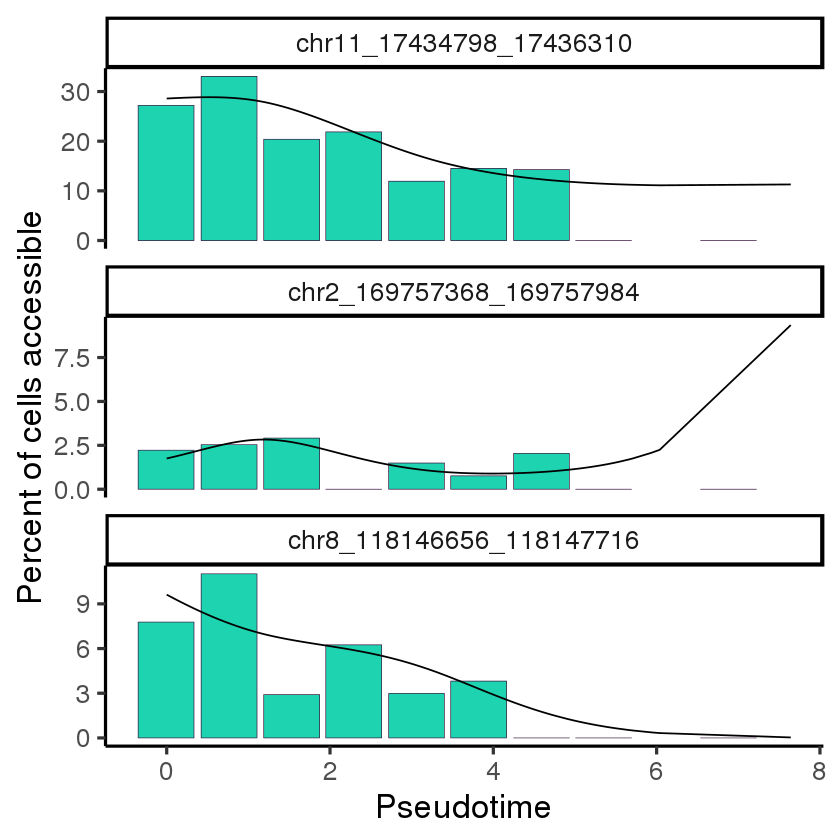

ERROR: Error in intI(i, n = x@Dim[1], dn[[1]], give.dn = FALSE): invalid character indexing


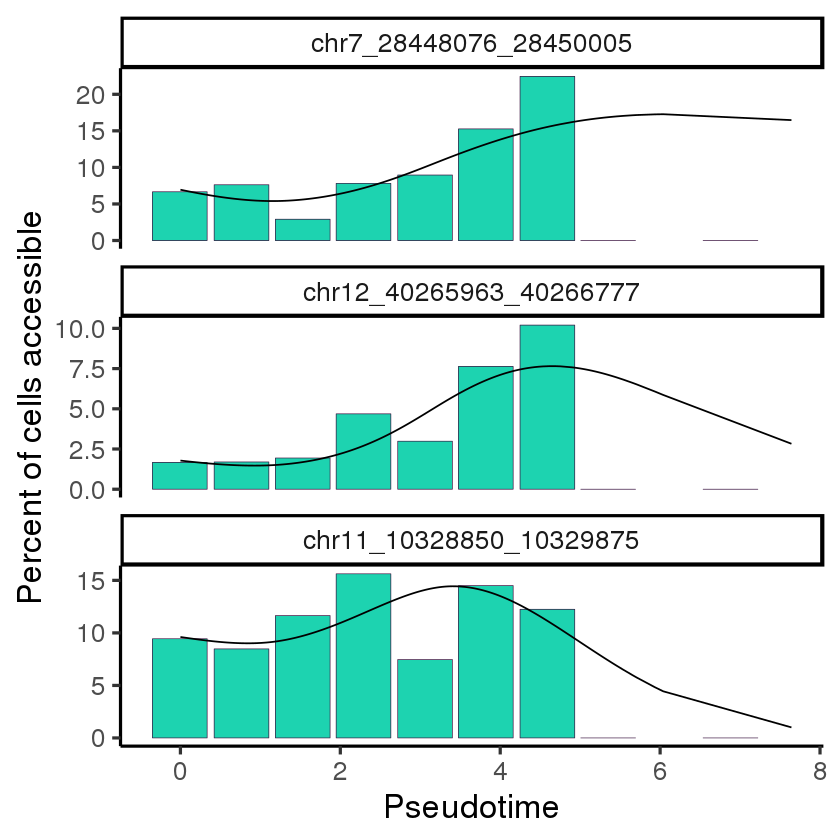

In [61]:
#agg_cds <- readRDS(file.path('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/', 'Islet_123.beta.agg_cds.pseudotime.rds'))

#clustering_DA_sites <- differentialGeneTest(agg_cds, fullModelFormulaStr = '~delta', cores=24)
ordering_sites <- row.names(subset(clustering_DA_sites, qval < .005))
agg_cds <- setOrderingFilter(agg_cds, ordering_sites)
agg_cds <- reduceDimension(agg_cds, max_components = 2, residualModelFormulaStr='~as.numeric(num_genes_expressed)', reduction_method = 'DDRTree')
agg_cds <- orderCells(agg_cds)
agg_cds <- orderCells(agg_cds, root_state=2)
pData(agg_cds)$Pseudotime <- max(pData(agg_cds)$Pseudotime) - pData(agg_cds)$Pseudotime
pData(input_cds)$Pseudotime <- pData(agg_cds)[colnames(input_cds),]$Pseudotime
pData(input_cds)$State <- pData(agg_cds)[colnames(input_cds),]$State


options(repr.plot.width=7, repr.plot.height=7)
plot_cell_trajectory(agg_cds, color_by = 'State')# + theme_void(base_size=20)
#plot_accessibility_in_pseudotime(input_cds[c('chr11_2182082_2182759', 'chr13_28491300_28492612','chr11_65667520_65668303')], breaks=10) + theme_classic(base_size=20) 
plot_accessibility_in_pseudotime(input_cds[c('chr3_187387813_187388546', 'chr13_28491300_28492612','chr10_94448759_94450496')], breaks=10) + theme_classic(base_size=20) 
plot_accessibility_in_pseudotime(input_cds[c('chr11_17434798_17436310', 'chr2_169757368_169757984','chr8_118146656_118147716')], breaks=10) + theme_classic(base_size=20) 
plot_accessibility_in_pseudotime(input_cds[c('chr7_28448076_28450005', 'chr12_40265963_40266777','chr11_10328850_10329875')], breaks=10) + theme_classic(base_size=20) 
plot_accessibility_in_pseudotime(input_cds[c('chr10_75601838_75602652', 'chr14_78389790_78390388','chr14_77791276_77791815')], breaks=10) + theme_classic(base_size=20) 
plot_accessibility_in_pseudotime(input_cds[c('chr11_65667520_65668303', 'chr7_28448076_28450005','chr1_934937_936394')], breaks=10) + theme_classic(base_size=20) 


In [60]:
#agg_cds <- orderCells(agg_cds, root_state=2)
#pData(input_cds)$Pseudotime <- pData(agg_cds)[colnames(input_cds),]$Pseudotime
#pData(input_cds)$State <- pData(agg_cds)[colnames(input_cds),]$State
#
#
wd = '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime'
write.table(pData(agg_cds)[c('Pseudotime')], '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/delta.pseudotime2.txt', sep='\t', quote=F)
saveRDS(agg_cds, file.path(wd, 'Islet_123.delta.agg_cds.pseudotime2.rds'))
pData(input_cds)$cell_subtype <- cut(pData(input_cds)$Pseudotime, 5)
binned_input <- aggregate_by_cell_bin(input_cds, 'cell_subtype')
diff_test_res <- differentialGeneTest(binned_input,
    fullModelFormulaStr="~sm.ns(Pseudotime, df=3) + sm.ns(num_genes_expressed, df=3)",
    reducedModelFormulaStr="~sm.ns(num_genes_expressed, df=3)", cores=24)
diff_test_res <- diff_test_res[order(diff_test_res$qval),]
write.table(diff_test_res[,c('pval','qval','num_cells_expressed')], file.path(wd, 'Islet_123.delta.pseudotime_difftest2.txt'), sep='\t', quote=F)

Removing 1095 outliers


In [55]:
pData(input_cds)

,cells,cluster,log10_n_counts,Size_Factor,num_genes_expressed,delta,Pseudotime,State,cell_subtype
,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>
Islet3-fresh_CTGAAGCTAGGCAGAATTATGCGAGTACTGAC,Islet3-fresh_CTGAAGCTAGGCAGAATTATGCGAGTACTGAC,delta_1,3.997605,1.6073699,3326,1,0.1260550,3,"(-0.00846,0.846]"
Islet3-fresh_AGACACCTGCTCATGATTATGCGAGTACTGAC,Islet3-fresh_AGACACCTGCTCATGATTATGCGAGTACTGAC,delta_1,4.588081,6.1363367,11458,1,0.3691986,3,"(-0.00846,0.846]"
Islet3-fresh_AGCGATAGCGATCAGTGAGCCTTACCTATCCT,Islet3-fresh_AGCGATAGCGATCAGTGAGCCTTACCTATCCT,delta_2,4.100233,2.0120052,4254,2,5.6107229,2,"(5.07,5.92]"
Islet3-fresh_CTGAAGCTCTCTGGTATTCTAGCTTATAGCCT,Islet3-fresh_CTGAAGCTCTCTGGTATTCTAGCTTATAGCCT,delta_2,4.068891,2.0810457,4290,2,3.4560965,3,"(3.38,4.23]"
Islet3-fresh_TCCGGAGAGCTCATGACCTAGAGTGTACTGAC,Islet3-fresh_TCCGGAGAGCTCATGACCTAGAGTGTACTGAC,delta_2,4.298591,2.1159011,4481,2,5.5394515,2,"(5.07,5.92]"
Islet3-fresh_TAATGCGCCTCTCTACCTCTCTATGGTTGCGT,Islet3-fresh_TAATGCGCCTCTCTACCTCTCTATGGTTGCGT,delta_1,3.989450,1.6650153,3496,1,0.3728868,3,"(-0.00846,0.846]"
Islet3-fresh_AGCGATAGAAGAGGCACTAAGCCTAGGCGAAG,Islet3-fresh_AGCGATAGAAGAGGCACTAAGCCTAGGCGAAG,delta_2,4.379505,3.8836952,7770,2,4.3302382,3,"(4.23,5.07]"
Islet3-fresh_ATTACTCGGGACTCCTCTCTCTATGGTTGCGT,Islet3-fresh_ATTACTCGGGACTCCTCTCTCTATGGTTGCGT,delta_1,3.654177,0.7377725,1594,1,1.3572710,3,"(0.846,1.69]"
Islet3-fresh_CTGAAGCTTAGCGCTCTTCTAGCTGTACTGAC,Islet3-fresh_CTGAAGCTTAGCGCTCTTCTAGCTGTACTGAC,delta_1,4.540217,5.7944857,10748,1,0.1615927,3,"(-0.00846,0.846]"


In [57]:
agg_cds <- readRDS(file.path('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/', 'Islet_123.delta.agg_cds.pseudotime2.rds'))
pData(input_cds)$Pseudotime <- pData(agg_cds)[colnames(input_cds),]$Pseudotime
pData(input_cds)$State <- pData(agg_cds)[colnames(input_cds),]$State
pData(input_cds)$cell_subtype <- cut(pData(input_cds)$Pseudotime, 4)
binned_input <- aggregate_by_cell_bin(input_cds, 'cell_subtype')
difftest_res <- read.table('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/Islet_123.delta.pseudotime_difftest2.txt', sep='\t', header=T)
difftest_res <- difftest_res[(rownames(difftest_res) %in% rownames(exprs(binned_input))) & (difftest_res$qval < .1),]
difftest_res$slope <- lapply(rownames(difftest_res), function(x){lm(exprs(binned_input)[x,] ~ seq(1:10))$coefficients[2]})
difftest_res$slope <- unlist(difftest_res$slope)
write.table(difftest_res, '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/delta.pseudotime_difftest2.slope.txt', sep='\t', quote=F)


Removing 1658 outliers
Warning message in file(file, "rt"):
"cannot open file '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/Islet_123.delta.pseudotime_difftest2.txt': No such file or directory"

ERROR: Error in file(file, "rt"): cannot open the connection


In [7]:
# redo pseudotime with 20 bins

wd <- '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime'
ptime <- read.table(file.path(wd, 'beta.pseudotime2.txt'), sep='\t', header=TRUE, row.names=1)
pData(input_cds) <- cbind(pData(input_cds), ptime)
pData(input_cds)$cell_subtype <- cut(pData(input_cds)$Pseudotime, 20)
binned_input <- aggregate_by_cell_bin(input_cds, 'cell_subtype')
diff_test_res <- differentialGeneTest(binned_input,
    fullModelFormulaStr="~sm.ns(Pseudotime, df=3) + sm.ns(num_genes_expressed, df=3)",
    reducedModelFormulaStr="~sm.ns(num_genes_expressed, df=3)", cores=24)
write.table(diff_test_res, file.path(wd, 'alpha.pseudotime_difftest3.txt'), sep='\t', quote=F)

difftest_res <- diff_test_res[,c('pval','qval','num_cells_expressed')]
difftest_res <- difftest_res[(rownames(difftest_res) %in% rownames(exprs(binned_input))) & (difftest_res$qval < .1),]
difftest_res$slope <- lapply(rownames(difftest_res), function(x){lm(exprs(binned_input)[x,] ~ seq(1:20))$coefficients[2]})
difftest_res$slope <- unlist(difftest_res$slope)
write.table(difftest_res, file.path(wd, 'alpha.pseudotime_difftest3.slope.txt'), sep='\t', quote=F)


In [3]:
set.seed(0)

wd = '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/cicero'
sc.data <- t(readMM(file.path(wd, 'Islet_123.peaks.mtx')))
peaks <- read.table(file.path(wd, 'Islet_123.peaks.peaks'), header=F)
barcodes <- read.table(file.path(wd, 'Islet_123.peaks.barcodes'), header=F)
rownames(sc.data) <- paste0('chr', gsub('-','_', gsub(':','_',peaks[,1])))
colnames(sc.data) <- barcodes[,1]

sc.umap <- read.table(file.path('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/', 'Islet_123.MNN_corrected.cluster_labels.filt.txt'), sep='\t', header=T, row.names=1)
cellinfo <-data.frame(cells=colnames(sc.data))
cellinfo <- cbind(cellinfo, sc.umap[c('cluster','log10_n_counts')])
row.names(cellinfo) <- cellinfo$cells
dhsinfo <- data.frame(site_name=rownames(sc.data))
dhsinfo <- cbind(dhsinfo, stringr::str_split_fixed(dhsinfo$site_name, "_", 3))
row.names(dhsinfo) <- dhsinfo$site_name
names(dhsinfo) <- c('site_name','chr','bp1','bp2')
dhsinfo$chr <- gsub('chr','', dhsinfo$chr)
dhsinfo$bp1 <- as.numeric(as.character(dhsinfo$bp1))
dhsinfo$bp2 <- as.numeric(as.character(dhsinfo$bp2))

clusters <- c('delta_1','delta_2')
input_cds <- suppressWarnings(newCellDataSet(as(sc.data, 'dgCMatrix'),
                            phenoData = methods::new('AnnotatedDataFrame', data = cellinfo),
                            featureData = methods::new('AnnotatedDataFrame', data = dhsinfo),
                            expressionFamily=negbinomial.size(),
                            lowerDetectionLimit=0))
input_cds@expressionFamily <- binomialff()
input_cds@expressionFamily@vfamily <- 'binomialff'
input_cds <- input_cds[, pData(input_cds)[['cluster']] %in% clusters]
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) > 0,]
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)

pData(input_cds)['delta'] <- as.numeric(gsub('delta_', '', pData(input_cds)$cluster))

agg_cds <- aggregate_nearby_peaks(input_cds, distance = 10000)
agg_cds <- detectGenes(agg_cds)
agg_cds <- estimateSizeFactors(agg_cds)
agg_cds <- estimateDispersions(agg_cds)
pData(agg_cds)$donor = stringr::str_split_fixed(pData(agg_cds)$cells, '-', 2)[,1]

agg_cds <- readRDS(file.path('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/', 'Islet_123.delta.agg_cds.pseudotime.rds'))

clustering_DA_sites <- differentialGeneTest(agg_cds, fullModelFormulaStr = '~delta')
ordering_sites <- row.names(subset(clustering_DA_sites, qval < .1))
agg_cds <- setOrderingFilter(agg_cds, ordering_sites)
agg_cds <- reduceDimension(agg_cds, max_components = 2, residualModelFormulaStr='~as.numeric(num_genes_expressed)', reduction_method = 'DDRTree')
agg_cds <- orderCells(agg_cds, reverse=TRUE)
pData(agg_cds)$Pseudotime <- max(pData(agg_cds)$Pseudotime) - pData(agg_cds)$Pseudotime
pData(input_cds)$Pseudotime <- pData(agg_cds)[colnames(input_cds),]$Pseudotime
pData(input_cds)$State <- pData(agg_cds)[colnames(input_cds),]$State


options(repr.plot.width=7, repr.plot.height=7)
plot_cell_trajectory(agg_cds, color_by = 'Pseudotime')# + theme_void(base_size=20)
plot_accessibility_in_pseudotime(input_cds[c('chr3_187387813_187388546', 'chr13_28491300_28492612','chr10_94448759_94450496')], breaks=10) + theme_classic(base_size=20) 
#plot_accessibility_in_pseudotime(input_cds[c('chr2_163007714_163009071', 'chrX_25033367_25034627', 'chr5_2750567_2752509')], breaks=10) + theme_classic(base_size=20) 
write.table(pData(agg_cds)[c('Pseudotime')], '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/delta.pseudotime2.txt', sep='\t', quote=F)

pData(input_cds)$cell_subtype <- cut(pData(input_cds)$Pseudotime, 10)
binned_input <- aggregate_by_cell_bin(input_cds, 'cell_subtype')
binned_diff <- exprs(binned_input)[rownames(diff_test_res[diff_test_res$qval < .05,]),]
upreg <- binned_diff[binned_diff[,1] > binned_diff[,10],]
write.table(diff_test_res[rownames(upreg),], '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/Islet_123.delta.pseudotime_difftest.upreg.txt', sep='\t', quote=F)
downreg <- binned_diff[binned_diff[,1] < binned_diff[,10],]
write.table(diff_test_res[rownames(downreg),], '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/Islet_123.delta.pseudotime_difftest.downreg.txt', sep='\t', quote=F)


In [ ]:
wd = '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/cicero'

beta <- readRDS(file.path(wd, 'Islet_123.beta_1.1MB_cicero_conns.rds'))
alpha <- readRDS(file.path(wd, 'Islet_123.alpha_1.1MB_cicero_conns.rds'))
gene_annotation <- read.table('/home/joshchiou/references/gencode.v19.cicero_gene_annotation.txt', header=T, stringsAsFactors=FALSE)

chr = 'chr11'
start = 1700000
end = 2700000

plot_list <- plot_connections(beta, chr, start, end,
#                              viewpoint='chr2_163008000_163010000',
                              viewpoint='chr11_2175000_2190000',
                              gene_model=gene_annotation,
                              connection_color = 'darkgreen',
                              peak_color = 'black',
#                              connection_ymax=0.25,
                              coaccess_cutoff=0.05,
                              comparison_track = alpha,
                              comparison_connection_color = 'darkred',
                              comparison_peak_color = 'black',
#                              comparison_ymax=0.25,
                              comparison_coaccess_cutoff=0.1,
                              gene_model_color='#7EC0EE',
                              viewpoint_color='#808080',
                              viewpoint_fill='#D3D3D3',
                              alpha_by_coaccess=TRUE,
                              connection_width=2,
                              collapseTranscripts='gene', 
                              return_as_list=TRUE)

options(repr.plot.width=12, repr.plot.height=8)

Gviz::plotTracks(plot_list,  
                 sizes=c(.5,.1,.25,.5,.1,.35),
                 from=start, to=end, chromosome=chr, 
                 transcriptAnnotation='symbol',
                 col.axis='black',
                 fontsize=16,
                 fontsize.group=20,
                 fontcolor.legend='black',
                 lwd=.3,
                 title.width=.5,
                 background.title='transparent', 
                 col.border.title='transparent')
        

In [1]:
wd = '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/cicero'

cell_type = 'beta_1'

conns <- readRDS(file.path(wd, paste0('Islet_123.', cell_type, '.1MB_cicero_conns.rds')))
conns <- conns[conns[['coaccess']]>=.05, ]
gene_annotation <- read.table('/home/joshchiou/references/gencode.v19.cicero_gene_annotation.txt', header=T, stringsAsFactors=FALSE)

#chr11:1739765-2625925 INS
#chr3:187326374-187448521 SST
#chr10:94426769-94478320 HHEX
#chr3:172093923-172233404
#chr2:162609965-163361878 GCG
chr = 'chr11'
start = 2100000 #187312000
end = 3100000 #187464000

plot_list <- plot_connections(conns, chr, start, end, 
                              gene_model=gene_annotation,
                              viewpoint='chr11_2690041-2692593',
                              connection_color = 'grey',
                              peak_color = 'black',
                              alpha_by_coaccess=TRUE,
                              coaccess_cutoff=0.05, 
                              connection_width=2,
                              gene_model_color='#7EC0EE',
                              viewpoint_color='#808080',
                              viewpoint_fill='#D3D3D3',
                              collapseTranscripts='gene', 
                              return_as_list=TRUE)

options(repr.plot.width=12, repr.plot.height=4.5)

Gviz::plotTracks(plot_list,  
                 sizes=c(.5,.1,.25,.35),
                 from=start, to=end, chromosome=chr, 
                 transcriptAnnotation='symbol',
                 col.axis='black',
                 fontsize=16,
                 fontsize.group=20,
                 fontcolor.legend='black',
                 lwd=.3,
                 title.width=.5,
                 background.title='transparent', 
                 col.border.title='transparent')
        

In [ ]:
wd <- '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/cicero'
input_cds <- readRDS(file.path(wd, 'Islet_123.beta_1.1MB_cicero_input_cds.rds'))
ins = exprs(input_cds)['chr11_2182082_2182759',]

ccan_1774 <- c('chr11_1884551_1885118','chr11_1903748_1903981','chr11_1974839_1975068','chr11_2008367_2008581'
               ,'chr11_2148671_2149141','chr11_2158461_2158837','chr11_2159405_2160815','chr11_2170878_2171277'
               ,'chr11_2173068_2173528','chr11_2173569_2173819','chr11_2174784_2175756','chr11_2178609_2178811'
               ,'chr11_2179555_2179780','chr11_2187411_2188036','chr11_2200112_2200645'
               ,'chr11_2210925_2212550','chr11_2218434_2218932','chr11_2229497_2229740','chr11_2229951_2230453'
               ,'chr11_2232185_2233107','chr11_2421333_2422146','chr11_2430814_2431792','chr11_2441813_2442303'
               ,'chr11_2553894_2554740','chr11_2634050_2634598','chr11_2738197_2738397','chr11_2799522_2800899'
               ,'chr11_2812713_2813446','chr11_2828549_2829139','chr11_2911958_2912167','chr11_2966625_2966979'
               ,'chr11_3079961_3080164','chr11_3131407_3131644','chr11_3399993_3400690','chr11_3519645_3519928'
               ,'chr11_3601414_3601775','chr11_3601835_3602716','chr11_3680842_3681056')
expr_1774 <- exprs(input_cds)[ccan_1774, ]
sum_1774 <- Matrix::colSums(expr_1774)

ones = 0
zeroes = 0
exprs = exprs(input_cds)
for (idx in names(ins)) {
    if ((ins[idx]==1) | (sum_1774[idx]>3)) {
        ones = ones + 1
        if (ones %% 11==0) {
            exprs['chr11_2690941_2691593', idx] = 1
        }
    }
    else {       
        if (zeroes %% 6!=0) {
            exprs['chr11_2690941_2691593', idx] = 0
        }
    }
}
print(sum(exprs['chr11_2690941_2691593',]))
##fData(input_cds)[(fData(input_cds)['chr']=='11') & (fData(input_cds)['bp1']>2100000),]

In [2]:
set.seed(0)

wd = '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/cicero'
sc.data <- t(readMM(file.path(wd, 'Islet_123.peaks.mtx')))
peaks <- read.table(file.path(wd, 'Islet_123.peaks.peaks'), header=F)
barcodes <- read.table(file.path(wd, 'Islet_123.peaks.barcodes'), header=F)
rownames(sc.data) <- paste0('chr', gsub('-','_', gsub(':','_',peaks[,1])))
colnames(sc.data) <- barcodes[,1]

clusters <- c('delta_1','delta_2')
sc.umap <- read.table(file.path(wd, 'Islet_123.MNN_corrected.cluster_labels.txt'), sep='\t', header=T, row.names=1)
sc.umap.subset <- sc.umap[sc.umap[['cluster']] %in% clusters,]

sc.data.subset <- sc.data[,rownames(sc.umap.subset)] > 0
cellinfo <-data.frame(cells=colnames(sc.data.subset))
row.names(cellinfo) <- cellinfo$cells
dhsinfo <- data.frame(site_name=rownames(sc.data.subset))
row.names(dhsinfo) <- dhsinfo$site_name
dhsinfo <- cbind(dhsinfo, stringr::str_split_fixed(dhsinfo$site_name, "_", 3))
names(dhsinfo) <- c('site_name','chr','bp1','bp2')
dhsinfo$chr <- gsub('chr','', dhsinfo$chr)
dhsinfo$bp1 <- as.numeric(as.character(dhsinfo$bp1))
dhsinfo$bp2 <- as.numeric(as.character(dhsinfo$bp2))

input_cds <- suppressWarnings(newCellDataSet(as(sc.data.subset, 'dgCMatrix'),
                            phenoData = methods::new('AnnotatedDataFrame', data = cellinfo),
                            featureData = methods::new('AnnotatedDataFrame', data = dhsinfo),
                            expressionFamily=negbinomial.size(),
                            lowerDetectionLimit=0))
input_cds@expressionFamily <- binomialff()
input_cds@expressionFamily@vfamily <- 'binomialff'
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)

input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)
input_cds <- input_cds[fData(input_cds)$num_cells_expressed > 0,]
umap_coords <- sc.umap.subset[c('UMAP1','UMAP2')]
colnames(umap_coords) <- NULL
#ps <- read.table('/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/pseudotime/alpha.pseudotime2.txt', sep='\t', header=T, row.names=1)
#colnames(ps) <- NULL
#input_cds <- reduceDimension(input_cds, max_components = 2, num_dim=10, reduction_method = 'tSNE', norm_method = "none")
#tsne_coords <- t(reducedDimA(input_cds))
#row.names(tsne_coords) <- row.names(pData(input_cds))


In [ ]:
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords, k=50)
window <- 1e6
data('human.hg19.genome')
distance_parameters <- estimate_distance_parameter(cicero_cds, window=window, maxit=100, sample_num=100, distance_constraint=500000, distance_parameter_convergence=1e-22, genomic_coords=human.hg19.genome, max_elements=200)
mean_distance_parameter <- mean(unlist(distance_parameters))
cicero_out <- generate_cicero_models(cicero_cds, distance_parameter=mean_distance_parameter, window=window, genomic_coords=human.hg19.genome, max_elements=1000)
conns <- assemble_connections(cicero_out, silent=FALSE)
saveRDS(conns, file.path(wd, paste0('Islet_123.', 'delta_all', '.1MB_cicero_conns.rds')))
write.table(conns, file.path(wd, paste0('Islet_123.', 'delta_all', '.cicero_conns.txt')), sep='\t', quote=FALSE, row.names=FALSE)

In [ ]:
input_cds <- suppressWarnings(newCellDataSet(exprs,
                            phenoData = methods::new('AnnotatedDataFrame', data = pData(input_cds)),
                            featureData = methods::new('AnnotatedDataFrame', data =  fData(input_cds)),
                            expressionFamily=negbinomial.size(),
                            lowerDetectionLimit=0))
input_cds@expressionFamily <- binomialff()
input_cds@expressionFamily@vfamily <- 'binomialff'
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)

In [ ]:
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)
input_cds <- input_cds[fData(input_cds)$num_cells_expressed > 0,]
input_cds <- reduceDimension(input_cds, max_components = 2, num_dim=10, reduction_method = 'tSNE', norm_method = "none")
tsne_coords <- t(reducedDimA(input_cds))
row.names(tsne_coords) <- row.names(pData(input_cds))

cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = tsne_coords, k=30)
window <- 1e6
data('human.hg19.genome')
distance_parameters <- estimate_distance_parameter(cicero_cds, window=window, maxit=100, sample_num=100, distance_constraint=500000, distance_parameter_convergence=1e-22, genomic_coords=human.hg19.genome, max_elements=200)
mean_distance_parameter <- mean(unlist(distance_parameters))
cicero_out <- generate_cicero_models(cicero_cds, distance_parameter=mean_distance_parameter, window=window, genomic_coords=human.hg19.genome, max_elements=1000)
conns <- assemble_connections(cicero_out, silent=FALSE)
saveRDS(conns, file.path(wd, paste0('Islet_123.', 'beta_1', '.1MB_cicero_conns.rds')))
write.table(conns, file.path(wd, paste0('Islet_123.', 'beta_1', '.cicero_conns.txt')), sep='\t', quote=FALSE, row.names=FALSE)


In [2]:
wd <- '/home/joshchiou/joshchiou-data2/islet_snATAC/fresh_only/cicero/'
cells <- c('beta_all','alpha_all')
for (c in cells) {
    file <- 
    conns <- readRDS(file.path(wd, paste0('Islet_123.', c,'.1MB_cicero_conns.rds')))
    ccans <- generate_ccans(conns)#, coaccess_cutoff_override=.1)
    write.table(ccans, file.path(wd, paste0('Islet_123.', c, '.cicero_ccans.txt')), sep='\t', quote=FALSE, row.names=FALSE)
}

[1] "Coaccessibility cutoff used: 0.16"
[1] "Coaccessibility cutoff used: 0.18"
